# Setup

In [6]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt 
%matplotlib inline

from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('english'))
from nltk import word_tokenize, ngrams

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import itertools
import xgboost as xgb

# Pre-processing

## Importing...

In [7]:
# df = pd.read_csv('pizza.csv')
# df = pd.read_csv('pizza.csv', parse_dates=['dates'])
# df = pd.read_csv('pizza.csv', usecols=['foo', 'bar'])

df = {
    "cooking": pd.read_csv('../dataset/processed/cooking.csv', usecols=['title', 'content']),
    "crypto": pd.read_csv('../dataset/processed/crypto.csv', usecols=['title', 'content']),
    "robotics": pd.read_csv('../dataset/processed/robotics.csv', usecols=['title', 'content']),
    "biology": pd.read_csv('../dataset/processed/biology.csv', usecols=['title', 'content']),
    "travel": pd.read_csv('../dataset/processed/travel.csv', usecols=['title', 'content']),
    "diy": pd.read_csv('../dataset/processed/diy.csv', usecols=['title', 'content']),
    #"physics": pd.read_csv('physics.csv'),
}

## Generating new .csv file with title+content and class columns...

In [8]:
with open('../dataset/processed/data.csv', 'w') as f:
    f.write('title_content|label\n')
    for _class in df:
        df[_class]['title_content'] = df[_class][['title', 'content']].apply(lambda x: '{} {}'.format(x[0],x[1]), axis=1)
        df[_class]['label'] = _class
        df[_class].to_csv(f, sep='|', columns=['title_content', 'label'], header=False, index=False)

# Data Analysis

## Exploration

In [9]:
dataset = pd.read_csv('../dataset/processed/data.csv', sep='|')
# dataset.head()
# dataset.tail()
dataset.sample(5)
# dataset.shape
dataset.describe()
# dataset.info()

,title_content,label
count,87000,87000
unique,86988,6
top,how connect phone line trying connect the phon...,diy
freq,2,25918


## Labels distribution

### Absolut numbers & Percentage

In [10]:
labels = dataset['label'].value_counts()
print(labels.describe())
print(labels.sort_index())
print(labels.sort_index()/labels.sum()*100)

count        6.000000
mean     14500.000000
std       7872.042454
min       2771.000000
25%      11123.000000
50%      14300.000000
75%      18310.250000
max      25918.000000
Name: label, dtype: float64
biology     13196
cooking     15404
crypto      10432
diy         25918
robotics     2771
travel      19279
Name: label, dtype: int64
biology     15.167816
cooking     17.705747
crypto      11.990805
diy         29.790805
robotics     3.185057
travel      22.159770
Name: label, dtype: float64


### Histogram

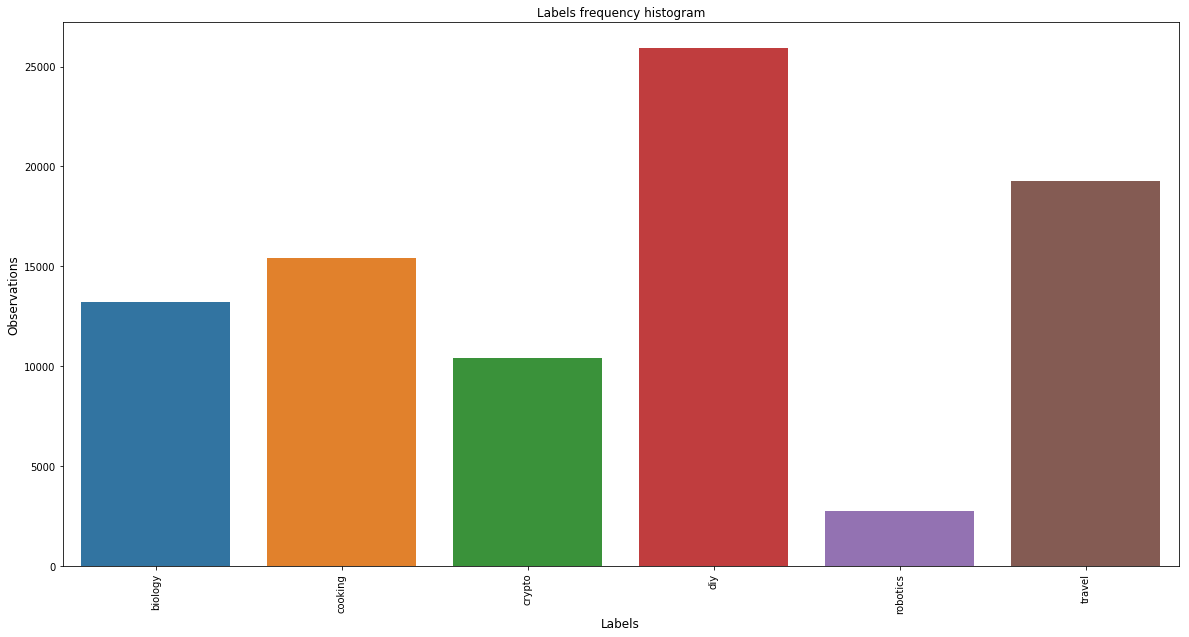

In [11]:
fig = plt.figure(figsize=(20, 10))
ax1 = sns.countplot(dataset['label'].sort_values())
plt.ylabel('Observations', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Labels frequency histogram')
plt.show()

## Word distribution

### Statistics of the number of words (size) of title_content text field

In [12]:
dataset['size'] = dataset['title_content'].apply(lambda x : len(str(x).split()))
sizes = dataset['size'].value_counts()

In [13]:
dataset['size'].describe()
print('The top 20 most frequent size of title_content, and their respective frequency:')
print(sizes.nlargest(20))

The top 20 most frequent size of title_content, and their respective frequency:
44    1065
39    1058
35    1055
42    1053
51    1023
45    1023
47    1016
50    1008
41    1008
37     995
36     989
55     983
38     982
46     978
40     959
33     956
32     953
34     952
31     949
43     948
Name: size, dtype: int64


### Histogram

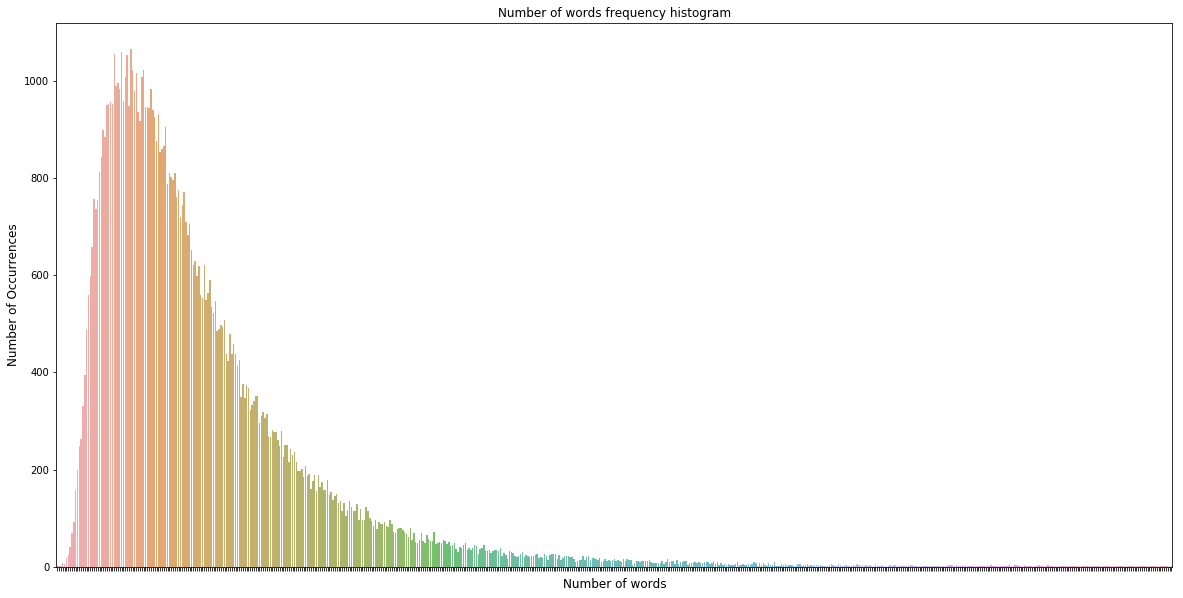

In [14]:
fig = plt.figure(figsize=(20, 10))
ax1 = sns.barplot(sizes.index, sizes.values, alpha=0.8)
ax1.set_xticklabels([])
plt.title('Number of words frequency histogram')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.show()

## Data example

### Robotics texts with more than 200 words

In [15]:
filtered_data = dataset[(dataset.label == 'robotics') & (dataset.title_content.apply(lambda x : len(str(x).split())) > 200)]
filtered_data.describe()

,size
count,237.000000
mean,299.438819
std,133.648324
min,201.000000
25%,226.000000
50%,257.000000
75%,318.000000
max,1276.000000


### Cell content example

In [16]:
line=61041
print('TEXT: {0}'.format(dataset.loc[61041, 'title_content']))
print('LABEL: {0}'.format(dataset.loc[61041, 'label']))
print('LENGTH: {0} words.'.format(len(dataset.loc[61041, 'title_content'].split())))

TEXT: visa needed for transit heatrow wife ukrainian citizen with romanian residency permit have tickets for flight madrid heatrow seoul see below details jue iberia turista madrid adolfo rez barajas terminal londres heathrow terminal jue british airways turista londres heathrow terminal seoul incheon want understand she needs transit visa not far that there the datv visa which can used you will not thourgh border control but don know this the case not will not have checkin our luggage but there any other border control that might have pass the terminals will change and not both flights will depart from terminal according this you don need apply for one you have eea family permit which seems the case this situation she not required any visa all
LABEL: travel
LENGTH: 124 words.


# Sampling

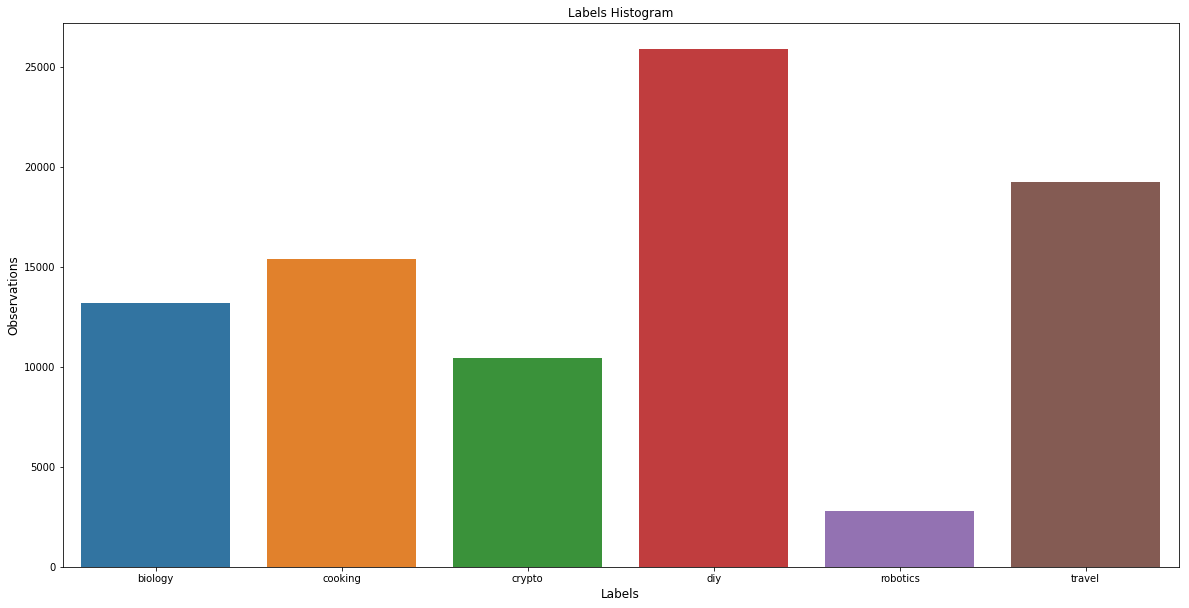

In [17]:
ds = {}
for label in labels.keys():
    ds[label] = dataset[dataset.label == label]
#     ds[label] = resample(ds[label], replace=False, n_samples=labels.min(), random_state=711)
ds = pd.concat(ds[label] for label in ds)

fig = plt.figure(figsize=(20, 10))
ax1 = sns.countplot(ds['label'].sort_values())
plt.ylabel('Observations', fontsize=12)
plt.xlabel('Labels', fontsize=12)
# plt.xticks(rotation='vertical')
plt.title('Labels Histogram')
plt.show()

# Bag-of-Words

In [18]:
tfidf = TfidfVectorizer(analyzer='word',
                        stop_words=STOP_WORDS,
                        ngram_range=(1,1),
                        max_df=0.7, min_df=2,
                        sublinear_tf=True)
X = tfidf.fit_transform(ds['title_content'])
print(X.shape)

l_enc = LabelEncoder()
y = l_enc.fit_transform(ds['label'])
print('Encoded labels: ', list([(i, l_enc.classes_[i]) for i in range(0, len(l_enc.classes_))]))

(87000, 37087)
Encoded labels:  [(0, 'biology'), (1, 'cooking'), (2, 'crypto'), (3, 'diy'), (4, 'robotics'), (5, 'travel')]


# Dimensionality reduction

In [19]:
svd = TruncatedSVD(n_components=1000, algorithm='randomized')
X_svd = svd.fit_transform(X)
print('Shape of svd matrix: ', X_svd.shape)

Shape of svd matrix:  (87000, 1000)


# Split Valid/Train/Test examples

In [20]:
# X = np.concatenate([svd_titulo, svd_resumo], axis=1)
X_temp, X_valid, y_temp, y_valid = train_test_split(X_svd, y, test_size=0.1, random_state=283)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=283)

print('X_train matrix shape is: {0}'.format(X_train.shape))
print('X_test matrix shape is: {0}'.format(X_test.shape))
print('X_valid matrix shape is: {0}'.format(X_valid.shape))
print('y_train matrix shape is: {0}'.format(y_train.shape))
print('y_test matrix shape: {0}'.format(y_test.shape))
print('y_valid matrix shape: {0}'.format(y_valid.shape))

X_train matrix shape is: (62640, 1000)
X_test matrix shape is: (15660, 1000)
X_valid matrix shape is: (8700, 1000)
y_train matrix shape is: (62640,)
y_test matrix shape: (15660,)
y_valid matrix shape: (8700,)


# Experiments

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.title(title + " normalized confusion matrix")
    else:
        plt.title(title + ' confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

## Naïve-Bayes Gaussian

Accuracy: 0.8056194125159643
[[1930   93   61  155   12  111]
 [ 434 2071    1  275    9   28]
 [ 175    6 1607   33   23   13]
 [ 326  152    6 3914   51  192]
 [  68    7    9   32  377   12]
 [ 566   29    4  147   14 2717]]


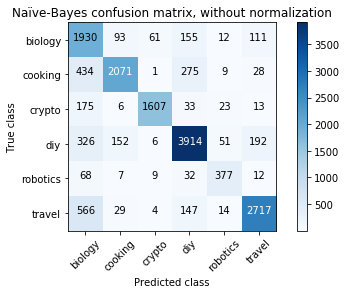

In [22]:
nbg = GaussianNB()
nbg.fit(X_train, y_train)
y_pred = nbg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix(cm, l_enc.classes_, title='Naïve-Bayes')

## Naïve-Bayes Bernoulli

Accuracy: 0.9079821200510856
[[2015   71   54  128    6   88]
 [  81 2399    8  231    0   99]
 [  34   15 1676   57    4   71]
 [  38   70   39 4427   10   57]
 [  14   13   29   37  396   16]
 [  26   17   13  114    1 3306]]


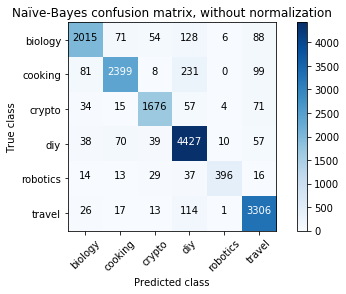

In [23]:
nbb = BernoulliNB()
nbb.fit(X_train, y_train)
y_pred = nbb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix(cm, l_enc.classes_, title='Naïve-Bayes')

## Random Forest

Accuracy: 0.9076628352490421
[[2079   80   40   92    7   64]
 [ 122 2492   10  156    1   37]
 [  78   11 1720   22    1   25]
 [  89   97   23 4390    2   40]
 [  68   15   50   68  283   21]
 [  82   41   15   88    1 3250]]


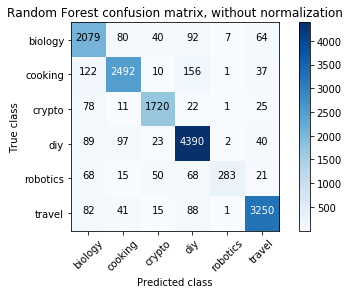

In [30]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix(cm, l_enc.classes_, title='Random Forest')

## SVM

Accuracy: 0.9748403575989782
[[2283   41    8   18    1   11]
 [  46 2704    1   47    1   19]
 [  21    2 1827    2    2    3]
 [  18   34    2 4574    6    7]
 [  11    0   11   26  456    1]
 [  22   12    2   18    1 3422]]


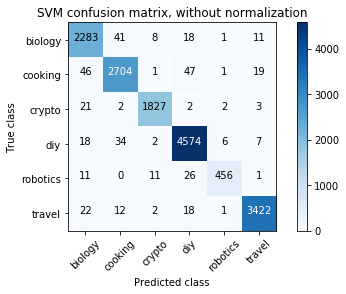

In [25]:
from sklearn import svm
lin_clf = svm.LinearSVC()
lin_clf.fit(X_train, y_train)

y_pred = lin_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix(cm, l_enc.classes_, title='SVM')

## Wisard

Accuracy: 0.296360153256705
[[   0    0    0 2362    0    0]
 [   0    0    0 2817    0    1]
 [   0    0    0 1857    0    0]
 [   0    0    0 4641    0    0]
 [   0    0    0  505    0    0]
 [   0    0    0 3477    0    0]]


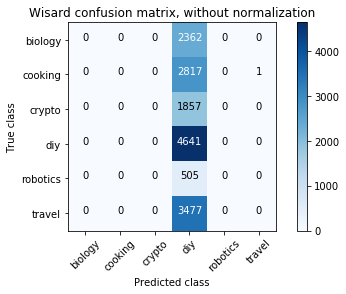

In [33]:
from WiSARD import WiSARD
import random

w = WiSARD(8, seed=random.randint(0, 2**32-1), ignore_zero_addr=True)
w.fit(X_train, y_train)
y_pred = w.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix(cm, l_enc.classes_, title='Wisard')